## Setup
First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## MNIST Data

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

There are 70k images, and each image has 784 features. This is because each image is 28 x 28 pixels, and each feature simply represents one pixel's intensity, from 0 (white) to 255 (black).

Saving figure some_digit_plot


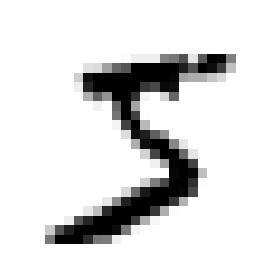

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
save_fig("some_digit_plot")
plt.show()

In [6]:
y[0] # the above output is indeed 5

'5'

In [7]:
# note: that the label is a string, so let's cast y to integer
y = y.astype(np.uint8)

The MNIST dataset is already split into a training (first 60000 images) and a test set (last 10000 images)

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

In [9]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

#### Stochastic Gradient Descent (SGD) classifier

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

sgd_clf.predict([some_digit])

array([ True])

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

Measuring accuracy using cross-validation

In [12]:
# implementing cross-validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

/Users/sankalp/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


0.95035
0.96035
0.9604


In [13]:
# a dumb classifier that classifies every single image in the 'not-5' class
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)

In [14]:
never5_clf = Never5Classifier()
cross_val_score(never5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

It has an accuracy of 90%! This is simply because only about 10% of images are 5s, so the guess if it is not a '5' will always be right 90% of the time.<br>
This is why accuracy is generally not preferred performance measure for classifiers especially when you are dealing with skewed dataset.

#### Confusion Matrix
The general idea is to count the no. of times instances of class A are classified as class B.

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

54892 => true negative <br>
687 => false positive<br>
1891 => false negative<br>
3530 => true positive<br>

row represent an <i>actual</i> class, column represents <i>predicted</i> class

A perfect classifier would have non-zero values only on its main diagonal.

In [17]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [18]:
from sklearn.metrics import precision_score, recall_score

#### Precision
precision = TP/(TP+FP)

In [19]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

This implies that when the classifier claims that an image represents a 5, it is correct only 83.70% of the time.

#### Recall
recall = TP/(TP + FN)

In [20]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

It only detects 65.11% of the 5s.

#### F1 Score
The F1 score is the <i>harmonic</i> mean of precision and recall. <br>
Whereas the <i>regular</i> mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a higher F1 score if both recall and precision are high.
<br>
F1 = TP/(TP + ((FN+FP)/2))

In [21]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

The F1 score favours classifiers that have similar precision and recall.<br>
This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall.
<br><br>
For example, if you train a classifier to detect videos that are safe for kids, you want low recall and high precision. On the other hand, suppose you train a classifier to detect shoplifters in surveillance images, you want high recall and low precision.
<br>
Unfortunately, you can't have it both ways: <b><i>increasing precision reduces recall, and vice versa.</i></b><br><br>
This is called the `precision/recall trade-off'.

#### Precision / recall trade-off

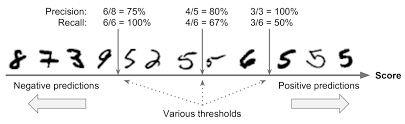
Suppose the decision threshold is positioned at the central arrow (between the two 5s): you will find 4 true positives(actual 5s) on the right of that threshold, and 1 false positive(actually a 6). Therefore with that threshold the precision is 80%(4 out of 5). But out of 6 actual 5s the classifier only detects 4,so the recall is 67%(4 out of 6). If you raise the threshold, the false positive(the 6) becomes a true negative, thereby increasing the precision (upto 100% in this case), but one true positive becomes a false negative, decreasing recall down to 50%.

In [29]:
# decision_function() returns a score for each instance
y_scores = sgd_clf.decision_function([some_digit])
y_scores

In [30]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

In [31]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

How to decide which threshold to use? first use the cross_val_predict() function to get the scores of all instances in the training set, but specify you want to return `decision_scores` instead of predictions:

In [32]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [40]:
# precision_recall_curve() is to compute precision and recall for all possible thresholds:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

array([-106527.45300471, -105763.22240074, -105406.2965229 , ...,
         38871.26391927,   42216.05562787,   49441.43765905])

Saving figure precision_recall_vs_threshold_plot


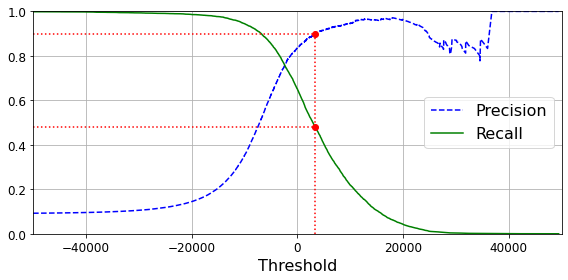

In [36]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")    
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown
    

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown

plt.show()

In [41]:
(y_train_pred == (y_scores > 0)).all()

True

Saving figure precision_vs_recall_plot


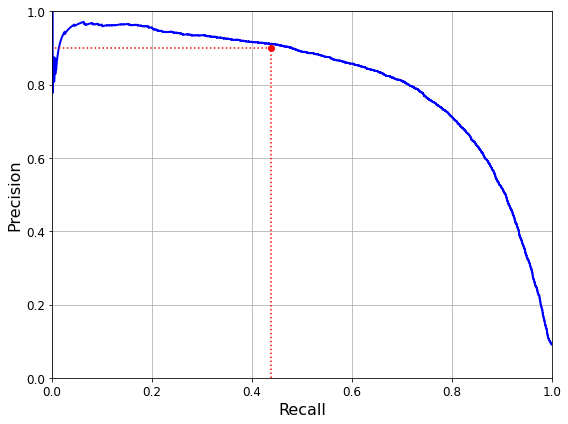

In [53]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.4368, 0.], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

In [55]:
# to aim for 90% precision, you need to use a threshold of about 8000. 
# to be more precise you can search for the lowest threshold that gives you at least 90% precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [58]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [59]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [60]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

It is fairly easy to create a classifier with any precision you want; just set a high enough threshold.<br>
<i>But a high-precision classifier is not useful if its recall is too low!</i>

## The ROC Curve